# Redo DESeq2 peak calling for Tycko CRISPRi GATA screen with low specificity sgRNAs removed prior to running DESeq2

Since they were included in the original SummarizedExperiment, the counts would have contributed to the overall variance at each time point so removing them post-DESeq2 would not be appropriate/the same as removing them from the analysis.

### Load libraries for data processing

In [1]:
suppressPackageStartupMessages(library(tidyverse))

### Prepare input data

#### Load sgRNA content for Bassik GATA1 library

Note that some sgRNAs may not have a GuideScan score and the coordinates most likely will not match those in the updated version of the GuideQuant files. Try joining on protospacer sequences or just interesct with bedtools.


In [12]:
grna <- read_csv("/data/gersbachlab/lrb53/encodeCrisprWG/lowspecguides/ammended_tycko_gata1_growth_PerturbTarget_in_hg38.csv",
                show_col_types = FALSE)
head(grna,n=1)
dim(grna)

chrPerturbationTarget,startPerturbationTarget,endPerturbationTarget,chrTSS,startTSS,endTSS,name,EffectSize,strandElement,strandGene,⋯,guidescanCuttingEfficiencyScore,guidescanCuttingSpecificityScore,offtargetsSum,EnrichmentRep1,StartCountsRep1,T14CountsRep1,EnrichmentRep2,StartCountsRep2,T14CountsRep2,guideType
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
chrX,48746012,48746031,chrX,48644962,48644962,chrX:48604416-48604435:+,-0.2427449,+,+,⋯,28,0.0015617,3201,-0.1011426,103,73,-0.3843473,103,89,tiling


[1] 10291    26

#### Load ENCODE guideQuant files, select guideID, type of guide, and read counts

In [13]:
tempdf <- read_tsv("/data/gersbachlab/lrb53/encodeCrisprWG/lowspecguides/guidequant/Plasmid_Bassik_guide_quantifications.bed", 
                    show_col_types = FALSE, 
                    col_names = FALSE) %>%
  mutate(grna_id = X7, type = X16, plasmid = X5, seq1 = X14, seq2 = X15) %>%
  select(grna_id, type, plasmid, seq1, seq2)

head(tempdf,n=1)
dim(tempdf)

grna_id,type,plasmid,seq1,seq2
<chr>,<chr>,<dbl>,<chr>,<chr>
chrX:48686620-48686623,tiling,208,GGGTCTATGGAGAAGTGGG,GGGGTCTATGGAGAAGTGGG


[1] 10036     5

In [14]:
plasmid <-
tempdf %>%
select(grna_id, type, plasmid, seq2) %>%
distinct() %>%
left_join(grna %>%
          rename(seq2 = guideSequence) %>%
          select(seq2, name, guidescanCuttingSpecificityScore, offtargetsSum) %>%
          distinct(),
          by = "seq2") %>% 
filter(guidescanCuttingSpecificityScore >= 0.2) 

head(plasmid,n=1)
dim(plasmid)

grna_id,type,plasmid,seq2,name,guidescanCuttingSpecificityScore,offtargetsSum
<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
chrX:48686632-48686635,tiling,288,GAGGGTTCAAGTAGGGTCTA,chrX:48545024-48545043:-,0.6921092,4


[1] 4929    7

**Filtering for score >= 0.2 removes 5,107 sgRNAs.**

In [15]:
t7i <- read_tsv("/data/gersbachlab/lrb53/encodeCrisprWG/lowspecguides/guidequant/T7_I_Bassik_guide_quantifications.bed", 
                    show_col_types = FALSE, 
                    col_names = FALSE) %>%
  mutate(grna_id = X7, type = X16, t7i = X5) %>%
  select(grna_id, type, t7i) 

dim(t7i)

[1] 9977    3

In [16]:
t21i.rep1 <- read_tsv("/data/gersbachlab/lrb53/encodeCrisprWG/lowspecguides/guidequant/T21_I_R1_Bassik_guide_quantifications.bed", 
                    show_col_types = FALSE, 
                    col_names = FALSE) %>%
  mutate(grna_id = X7, type = X16, t21i.rep1 = X5) %>%
  select(grna_id, type, t21i.rep1) 

dim(t21i.rep1)

[1] 9977    3

In [17]:
t21i.rep2 <- read_tsv("/data/gersbachlab/lrb53/encodeCrisprWG/lowspecguides/guidequant/T21_I_R2_Bassik_guide_quantifications.bed", 
                    show_col_types = FALSE, 
                    col_names = FALSE) %>%
  mutate(grna_id = X7, type = X16, t21i.rep2 = X5) %>%
  select(grna_id, type, t21i.rep2) 

dim(t21i.rep2)

[1] 9977    3

#### Combine replicates into one df, then filter out low-specificity sgRNAs (guidescan < 0.2 and 'NA')

In [18]:
df.i <- plasmid %>%
  filter(grepl("NT", grna_id) | grepl("chr", grna_id)) %>% ### does not remove any sgRNAs since already removed low spec and NA guides
  filter(!grepl("chrX:11",grna_id)) %>%
  select(grna_id, type, plasmid) %>%
  filter(grna_id %in% t21i.rep1$grna_id) %>% # removes an additional 20 sgRNAs
  left_join(t7i %>% select(-type), by = "grna_id") %>%
  left_join(t21i.rep1 %>% select(-type), by = "grna_id") %>%
  left_join(t21i.rep2 %>% select(-type), by = "grna_id")

dim(df.i) 

[1] 4908    6

In [19]:
head(df.i)

grna_id,type,plasmid,t7i,t21i.rep1,t21i.rep2
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
chrX:48686632-48686635,tiling,288,246,184,210
chrX:48686640-48686643,tiling,265,272,217,211
chrX:48686658-48686661,tiling,211,237,170,221
chrX:48686696-48686699,tiling,182,236,141,129
chrX:48686729-48686732,tiling,318,380,267,292
chrX:48686756-48686759,tiling,238,284,169,195


In [20]:
# plasmid %>%
# filter(grepl("NT", grna_id) | grepl("chr", grna_id)) %>% ### does not remove any sgRNAs since already removed low spec and NA guides
# rename(guideSequence = seq2) %>%
# filter(!grepl("chrX:11",grna_id)) %>% ### this guide maps to the GATA1 locus and another location on chrX
# filter(grna_id %in% t21i.rep1$grna_id) %>% # removes an additional 20 sgRNAs
# left_join(t7i %>% select(-type), by = "grna_id") %>%
# left_join(t21i.rep1 %>% select(-type), by = "grna_id") %>%
# left_join(t21i.rep2 %>% select(-type), by = "grna_id") %>%
# select(grna_id, name, guideSequence, guidescanCuttingSpecificityScore, type, plasmid, t7i, contains("t21")) %>%
# write.table("/data/gersbachlab/lrb53/encodeCrisprWG/lowspecguides/guidequant/bassik_crispri_gata1growth.removelowspec.final.txt",
#             col.names=T, row.names=F, quote=F, sep="\t")

#### Check for duplicates (sgRNAs with >1 value for count in at least one replicate)

In [21]:
df.i[duplicated(df.i$grna_id),]

grna_id,type,plasmid,t7i,t21i.rep1,t21i.rep2
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>


#### Generate metadata

In [22]:
samples.i <- colnames(df.i %>% select(-grna_id, -type))
meta.i <- data.frame(sample = samples.i, group = c("plasmid","day7","day21","day21"))

meta.i

sample,group
<chr>,<chr>
plasmid,plasmid
t7i,day7
t21i.rep1,day21
t21i.rep2,day21


#### Prepare counts and metadata for summarized experiment

In [23]:
df.i.clean <- as.matrix(df.i %>% select(-type, -grna_id))
row.names(df.i.clean) <- df.i$grna_id
coldata.i <- meta.i[,c("sample","group")]

### DESeq2

In [24]:
suppressPackageStartupMessages(library(DESeq2))

#### Make DESeq2 summarized experiment

In [25]:
se.i <- DESeqDataSetFromMatrix(
  countData = df.i.clean,
  colData = coldata.i,
  design = ~ group
)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


#### Run DESeq2

In [26]:
dds.i <- DESeq(se.i)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing



#### Generate results object

In [27]:
res.i.plasmidvsd7 <- results(dds.i, contrast = c("group","day7","plasmid"))
res.i.plasmidvsd21 <- results(dds.i, contrast = c("group","day21","plasmid")) 
res.i.d7vsd21 <- results(dds.i, contrast = c("group","day21","day7")) 

#### DESeq2 results

In [28]:
summary(res.i.plasmidvsd7)


out of 4908 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 12, 0.24%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 6)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [29]:
summary(res.i.plasmidvsd21)


out of 4908 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 1, 0.02%
LFC < 0 (down)     : 192, 3.9%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 6)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [30]:
summary(res.i.d7vsd21)


out of 4908 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 1, 0.02%
LFC < 0 (down)     : 122, 2.5%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 6)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



#### Add grna_id as column

In [31]:
# krab.plasmid.d7 <- as.data.frame(res.i.plasmidvsd7, row.names = NULL)
# krab.plasmid.d7$grna_id <- rownames(res.i.plasmidvsd7)
# krab.plasmid.d7 <- krab.plasmid.d7 %>% left_join(plasmid %>% select(grna_id, type) %>% distinct(), by = "grna_id")

krab.plasmid.d21 <- as.data.frame(res.i.plasmidvsd21, row.names = NULL)
krab.plasmid.d21$grna_id <- rownames(res.i.plasmidvsd21)
krab.plasmid.d21 <- krab.plasmid.d21 %>% left_join(plasmid %>% select(grna_id, type) %>% distinct(), by = "grna_id")

# krab.d7d21 <- as.data.frame(res.i.d7vsd21, row.names = NULL)
# krab.d7d21$grna_id <- rownames(res.i.d7vsd21)
# krab.d7d21 <- krab.d7d21 %>% left_join(plasmid %>% select(grna_id, type) %>% distinct(), by = "grna_id")

#### Write .tsv files

Combine contrast results into one df for each type of screen

In [32]:
# krab.res <- 
#   krab.plasmid.d7 %>%
#   dplyr::rename_with(~ paste("d7.vs.plasmid", .x, sep = "."), baseMean:padj) %>%
#   left_join(
#     krab.plasmid.d21 %>%
#       rename_with(~ paste("d21.vs.plasmid", .x, sep = "."), baseMean:padj),
#     by = c("grna_id","type"))  %>%
#   left_join(
#     krab.d7d21 %>%
#       rename_with(~ paste("d21.vs.d7", .x, sep = "."), baseMean:padj),
#     by = c("grna_id","type"))  %>%
#   dplyr::select(grna_id, type, d7.vs.plasmid.baseMean:d7.vs.plasmid.padj, d7.vs.plasmid.baseMean:d21.vs.d7.padj)

In [33]:
krab.res <- 
krab.plasmid.d21 %>%
rename_with(~ paste("d21.vs.plasmid", .x, sep = "."), baseMean:padj) %>%
select(grna_id, type, starts_with("d21"))

head(krab.res,n=1)
dim(krab.res)

,grna_id,type,d21.vs.plasmid.baseMean,d21.vs.plasmid.log2FoldChange,d21.vs.plasmid.lfcSE,d21.vs.plasmid.stat,d21.vs.plasmid.pvalue,d21.vs.plasmid.padj
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,chrX:48686632-48686635,tiling,230.629,-0.438347,0.3389427,-1.293278,0.195915,0.9999433


[1] 4908    8

In [34]:
write_tsv(krab.res, "/data/gersbachlab/lrb53/encodeCrisprWG/lowspecguides/removelowspec.tyckoGATA1krabinterference.deseq2.results.tsv", 
          col_names = TRUE)

### Visualization and QC

In [35]:
suppressPackageStartupMessages(library(vsn))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(pheatmap))

#### Extract transformed values

In [36]:
vsd <- vst(dds.i, blind = FALSE)

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



In [37]:
rld <- rlog(dds.i, blind = FALSE)

#### Log-transform, scale-shift

In [38]:
ntd <- normTransform(dds.i) # this gives log2(n+1)

#### Variance plots with different types of transformations/scaling

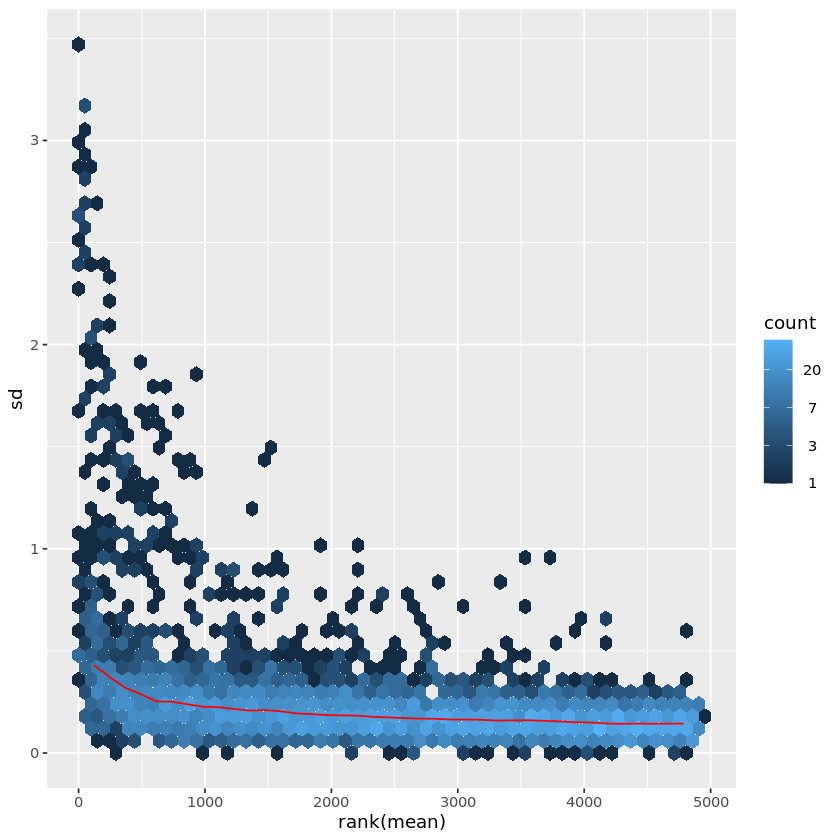

In [39]:
meanSdPlot(assay(ntd))

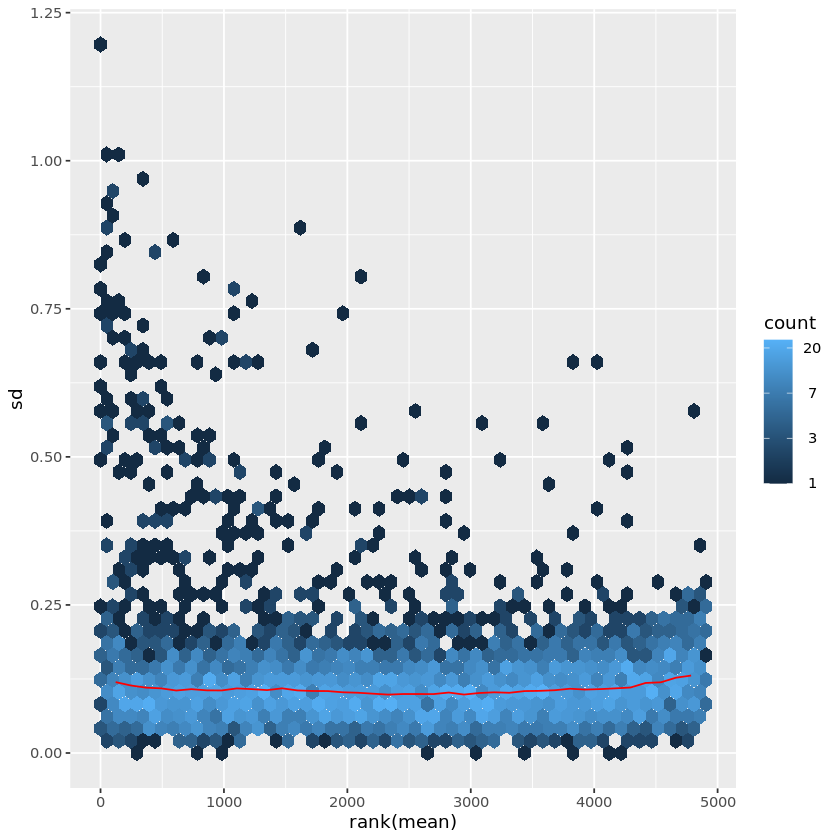

In [40]:
meanSdPlot(assay(vsd))

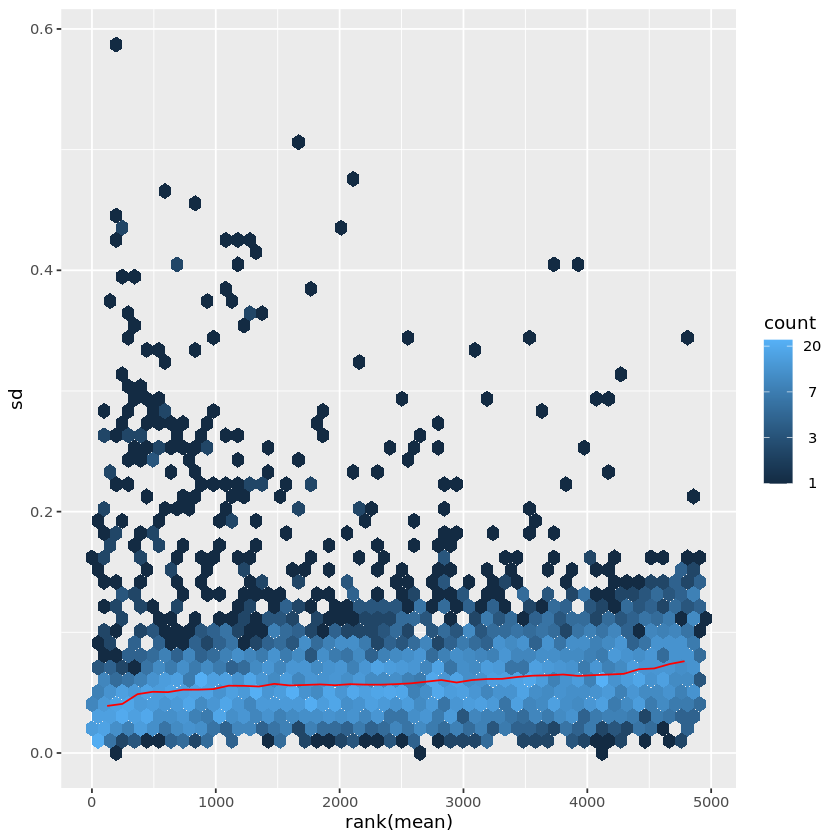

In [41]:
meanSdPlot(assay(rld))

#### PCA

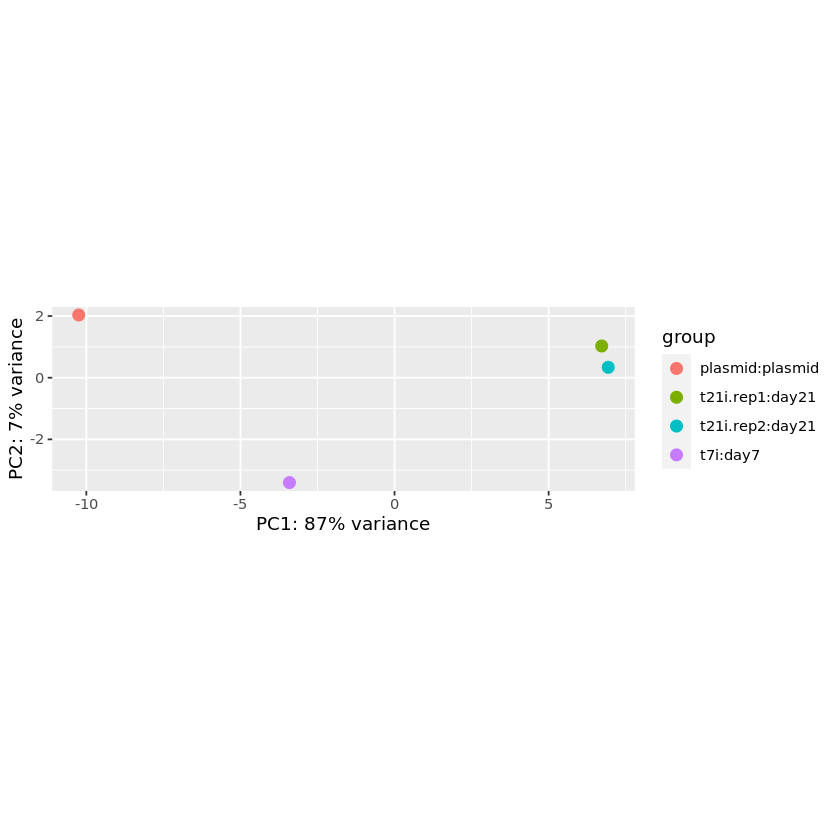

In [42]:
plotPCA(vsd, intgroup=c("sample", "group"))

#### Heatmap of sample-sample distance

In [43]:
sampleDists <- dist(t(assay(vsd)))

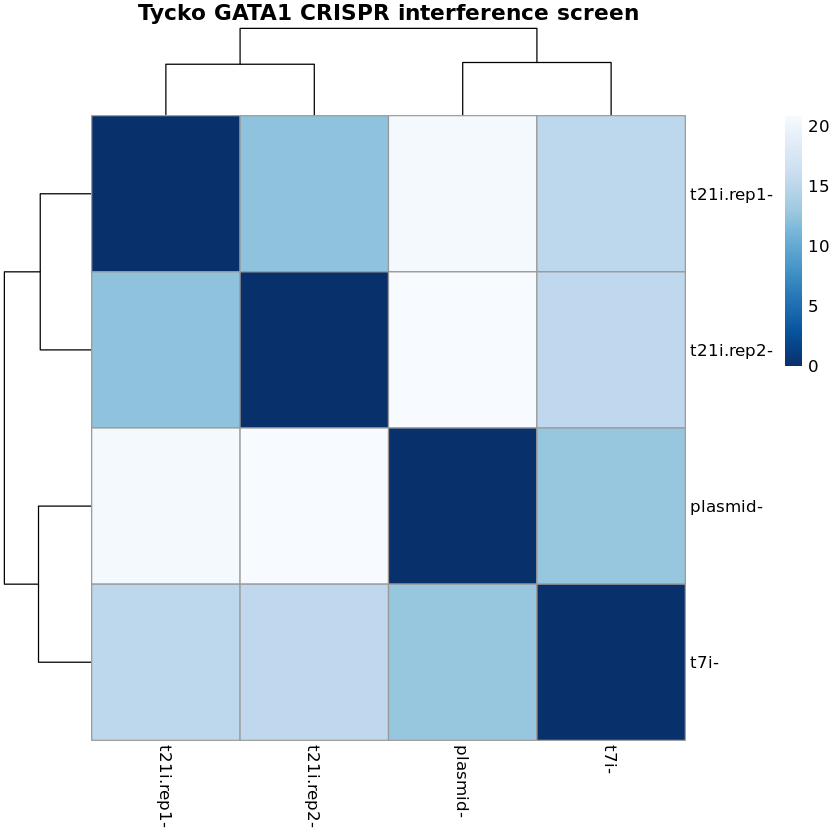

In [44]:
sampleDistMatrix <- as.matrix(sampleDists)
rownames(sampleDistMatrix) <- paste(vsd$sample, vsd$type, sep="-")
colnames(sampleDistMatrix) <- paste(vsd$sample, vsd$type, sep="-") # change to 'NULL' to get rid of bottom labels
colors <- colorRampPalette(rev(brewer.pal(9, "Blues")))(255)
pheatmap(sampleDistMatrix,
         clustering_distance_rows=sampleDists,
         clustering_distance_cols=sampleDists,
         col=colors,
         main = "Tycko GATA1 CRISPR interference screen")

### Aggregate sgRNA-level effects to call "peaks"

#### Define fisher's method to aggregate p values
 - https://mikelove.wordpress.com/2012/03/12/combining-p-values-fishers-method-sum-of-p-values-binomial/
 - https://www.biostars.org/p/211307/

In [5]:
fishersMethod = function(x) pchisq(-2 * sum(log(x)),df=2*length(x),lower=FALSE)

#### Re-load results (if needed)

In [3]:
krab.res <- read_tsv("/data/gersbachlab/lrb53/encodeCrisprWG/lowspecguides/removelowspec.tyckoGATA1krabinterference.deseq2.results.tsv",
                    show_col_types=FALSE)
head(krab.res,n=1)
dim(krab.res)

grna_id,type,d21.vs.plasmid.baseMean,d21.vs.plasmid.log2FoldChange,d21.vs.plasmid.lfcSE,d21.vs.plasmid.stat,d21.vs.plasmid.pvalue,d21.vs.plasmid.padj
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chrX:48686632-48686635,tiling,230.629,-0.438347,0.3389427,-1.293278,0.195915,0.9999433


[1] 4908    8

#### Load output of bedtools intersect 

Defines "bins" and which sgRNAs belong to each bin after adjusting for perturbation modality.

In [4]:
peaks <- read.delim("cutsitecoords/outs/cutsite.tycko.krab.100step.bed", header = FALSE, 
                    col.names = c("grna.chrom","grna.start","grna.end","grna_id","bin.chr","bin.start","bin.end")) %>%
  mutate(bin = paste0(bin.chr,":",bin.start,"-",bin.end))

head(peaks,n=1)
dim(peaks)

,grna.chrom,grna.start,grna.end,grna_id,bin.chr,bin.start,bin.end,bin
,<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>,<chr>
1,chrX,48686619,48686621,chrX:48686620-48686623,chrX,48686400,48686500,chrX:48686400-48686500


[1] 36197     8

#### Subset DESeq2 results for only targeting sgRNAs

In [6]:
pam <- krab.res %>%
  filter(type == "tiling")

head(pam,n=1)
dim(pam)

grna_id,type,d21.vs.plasmid.baseMean,d21.vs.plasmid.log2FoldChange,d21.vs.plasmid.lfcSE,d21.vs.plasmid.stat,d21.vs.plasmid.pvalue,d21.vs.plasmid.padj
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chrX:48686632-48686635,tiling,230.629,-0.438347,0.3389427,-1.293278,0.195915,0.9999433


[1] 4906    8

#### Number of significant bins (CREs) after removing low spec sgRNAs

In [7]:
length(
pam %>%
  left_join(peaks, by = "grna_id") %>%
  filter(grepl("chrX",bin)) %>%
  group_by(bin) %>%
  summarize(n = n(),
            fisher = fishersMethod(d21.vs.plasmid.pvalue), # Sager says use un-adjusted DESeq2 p-values here
            mean_logfc = mean(abs(d21.vs.plasmid.log2FoldChange)),
            max_logfc = max(abs(d21.vs.plasmid.log2FoldChange)),
            bin.mid = (bin.end+bin.start)/2) %>%
  select(bin, bin.mid, mean_logfc, max_logfc, fisher, n) %>%
  ungroup() %>%
  distinct() %>%
  mutate(fdr = p.adjust(fisher, method = "fdr")) %>% # then correct for the number of comparisons here
  mutate(sep = bin,
         sig = -log10(fdr)) %>%
  separate(sep, into = c("chrom","start","end")) %>%
  select(chrom, start, end, bin:sig) %>%
  filter(fdr < 0.1) %>%
  select(bin) %>%
  distinct() %>% pull()
       )

`summarise()` has grouped output by 'bin'. You can override using the `.groups`
argument.


[1] 163

Original analysis identified 381 regions as significant.

#### Filter for FDR < 0.1, write .bed files

In [49]:
# pam %>%
#   left_join(peaks, by = "grna_id") %>%
#   filter(grepl("chrX",bin)) %>%
#   group_by(bin) %>%
#   summarize(n = n(),
#             fisher = fishersMethod(d21.vs.plasmid.pvalue), # Sager says use un-adjusted DESeq2 p-values here
#             mean_logfc = mean(abs(d21.vs.plasmid.log2FoldChange)),
#             max_logfc = max(abs(d21.vs.plasmid.log2FoldChange)),
#             bin.mid = (bin.end+bin.start)/2) %>%
#   select(bin, bin.mid, mean_logfc, max_logfc, fisher, n) %>%
#   ungroup() %>%
#   distinct() %>%
#   mutate(fdr = p.adjust(fisher, method = "fdr")) %>% # then correct for the number of comparisons here
#   mutate(sep = bin,
#          sig = -log10(fdr)) %>%
#   separate(sep, into = c("chrom","start","end")) %>%
#   select(chrom, start, end, bin:sig) %>%
#   filter(fdr < 0.1) %>%
#   mutate(strand = ".") %>%
#   select(chrom:bin, sig, strand) %>%
#   write.table("/data/gersbachlab/lrb53/encodeCrisprWG/lowspecguides/removelowspec.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.fdr01.adjp.hg38.bed", 
#               col.names = FALSE, row.names = FALSE, quote = FALSE, sep = "\t")


`summarise()` has grouped output by 'bin'. You can override using the `.groups`
argument.


In [50]:
# pam %>%
#   left_join(peaks, by = "grna_id") %>%
#   filter(grepl("chrX",bin)) %>%
#   group_by(bin) %>%
#   summarize(n = n(),
#             fisher = fishersMethod(d21.vs.plasmid.pvalue), # Sager says use un-adjusted DESeq2 p-values here
#             mean_logfc = mean(abs(d21.vs.plasmid.log2FoldChange)),
#             max_logfc = max(abs(d21.vs.plasmid.log2FoldChange)),
#             bin.mid = (bin.end+bin.start)/2) %>%
#   select(bin, bin.mid, mean_logfc, max_logfc, fisher, n) %>%
#   ungroup() %>%
#   distinct() %>%
#   mutate(fdr = p.adjust(fisher, method = "fdr")) %>% # then correct for the number of comparisons here
#   mutate(sep = bin,
#          sig = -log10(fdr)) %>%
#   separate(sep, into = c("chrom","start","end")) %>%
#   select(chrom, start, end, bin:sig) %>%
#   filter(fdr < 0.1) %>%
#   mutate(strand = ".") %>%
#   select(chrom:bin, mean_logfc, strand) %>%
#   write.table("/data/gersbachlab/lrb53/encodeCrisprWG/lowspecguides/removelowspec.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.fdr01.abslog2fc.hg38.bed", 
#               col.names = FALSE, row.names = FALSE, quote = FALSE, sep = "\t")


`summarise()` has grouped output by 'bin'. You can override using the `.groups`
argument.


In [51]:
# pam %>%
#   left_join(peaks, by = "grna_id") %>%
#   filter(grepl("chrX",bin)) %>%
#   group_by(bin) %>%
#   summarize(n = n(),
#             fisher = fishersMethod(d21.vs.plasmid.pvalue), # Sager says use un-adjusted DESeq2 p-values here
#             mean_logfc = mean(abs(d21.vs.plasmid.log2FoldChange)),
#             max_logfc = max(abs(d21.vs.plasmid.log2FoldChange)),
#             bin.mid = (bin.end+bin.start)/2) %>%
#   select(bin, bin.mid, mean_logfc, max_logfc, fisher, n) %>%
#   ungroup() %>%
#   distinct() %>%
#   mutate(fdr = p.adjust(fisher, method = "fdr")) %>% # then correct for the number of comparisons here
#   mutate(sep = bin,
#          sig = -log10(fdr)) %>%
#   separate(sep, into = c("chrom","start","end")) %>%
#   select(chrom, start, end, bin:sig) %>%
#   filter(fdr < 0.1) %>%
#   mutate(strand = ".") %>%
#   select(chrom:bin, max_logfc, strand) %>%
#   write.table("/data/gersbachlab/lrb53/encodeCrisprWG/lowspecguides/removelowspec.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.fdr01.maxlog2fc.hg38.bed", 
#               col.names = FALSE, row.names = FALSE, quote = FALSE, sep = "\t")
 

`summarise()` has grouped output by 'bin'. You can override using the `.groups`
argument.


### Visualize results

In [14]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(ggpubr))

#### Load new peak calls

In [15]:
newpeaks <-
read.delim("/data/gersbachlab/lrb53/encodeCrisprWG/lowspecguides/removelowspec.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.fdr01.maxlog2fc.hg38.bed",
           header = FALSE, col.names = c("chrBin","startBin","endBin","bin","new_max_log2fc","strand")) %>%
left_join(read.delim("/data/gersbachlab/lrb53/encodeCrisprWG/lowspecguides/removelowspec.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.fdr01.abslog2fc.hg38.bed",
           header = FALSE, col.names = c("chrBin","startBin","endBin","bin","new_abs_log2fc","strand")) %>%
          select(bin, new_abs_log2fc),
          by = "bin") %>%
left_join(read.delim("/data/gersbachlab/lrb53/encodeCrisprWG/lowspecguides/removelowspec.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.fdr01.adjp.hg38.bed",
           header = FALSE, col.names = c("chrBin","startBin","endBin","bin","new_adjp","strand")) %>%
          select(bin, new_adjp),
          by = "bin") %>%
select(chrBin:endBin, strand, bin, new_adjp, contains("log2fc"))

head(newpeaks,n=1)
dim(newpeaks)

,chrBin,startBin,endBin,strand,bin,new_adjp,new_max_log2fc,new_abs_log2fc
,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,chrX,48696600,48696700,.,chrX:48696600-48696700,10.22434,7.047916,0.5778344


[1] 163   8

#### Load previous peak calls for comparison

In [16]:
oldpeaks <-
read.delim("/data/gersbachlab/lrb53/encodeCrisprWG/lowspecguides/cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.fdr01.maxlog2fc.hg38.bed",
           header = FALSE, col.names = c("chrBin","startBin","endBin","bin","old_max_log2fc","strand")) %>%
left_join(read.delim("/data/gersbachlab/lrb53/encodeCrisprWG/lowspecguides/cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.fdr01.abslog2fc.hg38.bed",
           header = FALSE, col.names = c("chrBin","startBin","endBin","bin","old_abs_log2fc","strand")) %>%
          select(bin, old_abs_log2fc),
          by = "bin") %>%
left_join(read.delim("/data/gersbachlab/lrb53/encodeCrisprWG/manuscript/deseq2/cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.fdr01.adjp.hg38.bed",
           header = FALSE, col.names = c("chrBin","startBin","endBin","bin","old_adjp","strand")) %>%
          select(bin, old_adjp),
          by = "bin") %>%
select(chrBin:endBin, strand, bin, old_adjp, contains("log2fc"))

head(oldpeaks,n=1)
dim(oldpeaks)

,chrBin,startBin,endBin,strand,bin,old_adjp,old_max_log2fc,old_abs_log2fc
,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,chrX,105822500,105822600,.,chrX:105822500-105822600,10.17501,3.606516,3.606516


[1] 381   8

#### Combine peak calls into one df with label for analysis

In [17]:
plotdf <-
oldpeaks %>%
left_join(newpeaks %>% select(bin, new_adjp:new_abs_log2fc),
          by = "bin") 
# %>%
# filter(!is.na(new_adjp)) ### 3 peaks called significant after removing low spec guides that were not significant in original analysis

head(plotdf,n=1)
dim(plotdf)

,chrBin,startBin,endBin,strand,bin,old_adjp,old_max_log2fc,old_abs_log2fc,new_adjp,new_max_log2fc,new_abs_log2fc
,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,chrX,105822500,105822600,.,chrX:105822500-105822600,10.17501,3.606516,3.606516,NA,NA,NA


[1] 381  11

In [18]:
length(intersect(oldpeaks$bin,newpeaks$bin))

[1] 160

In [19]:
length(setdiff(newpeaks$bin, oldpeaks$bin))

[1] 3

In [20]:
length(setdiff(oldpeaks$bin, newpeaks$bin))

[1] 221

Warning message:
“Removed 217 rows containing missing values (geom_point).”
`summarise()` has grouped output by 'bin_midpoint'. You can override using the
`.groups` argument.


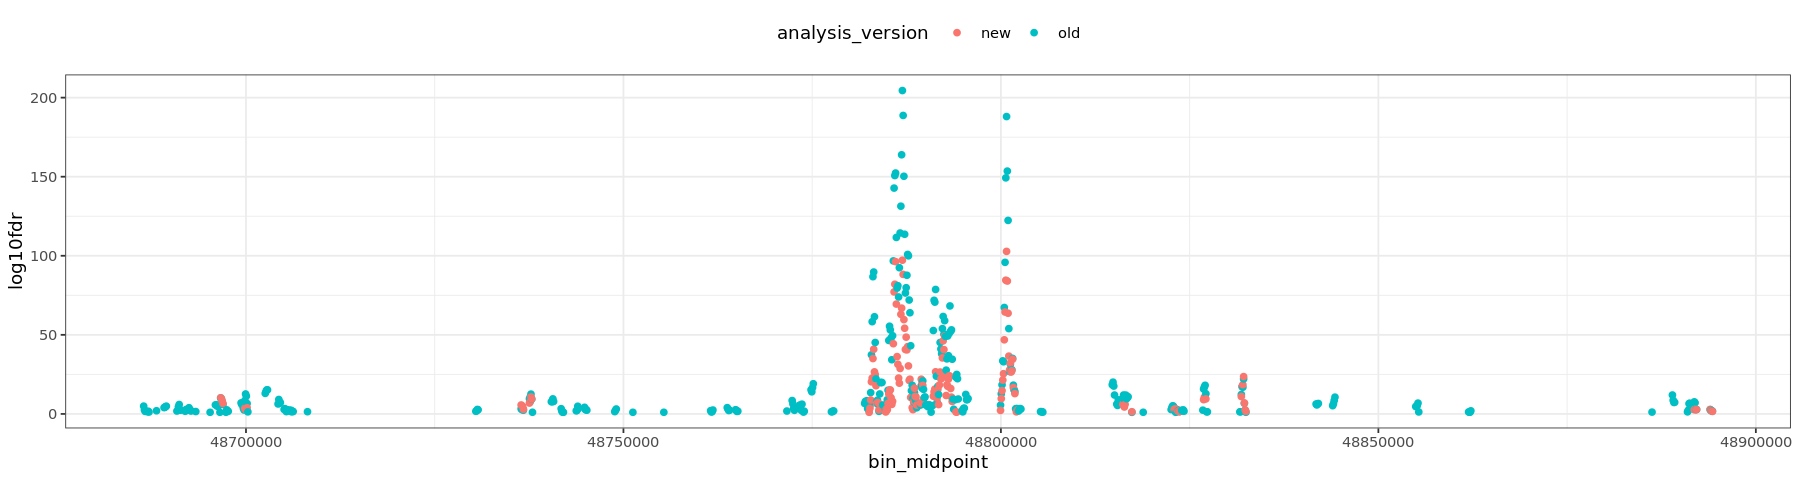

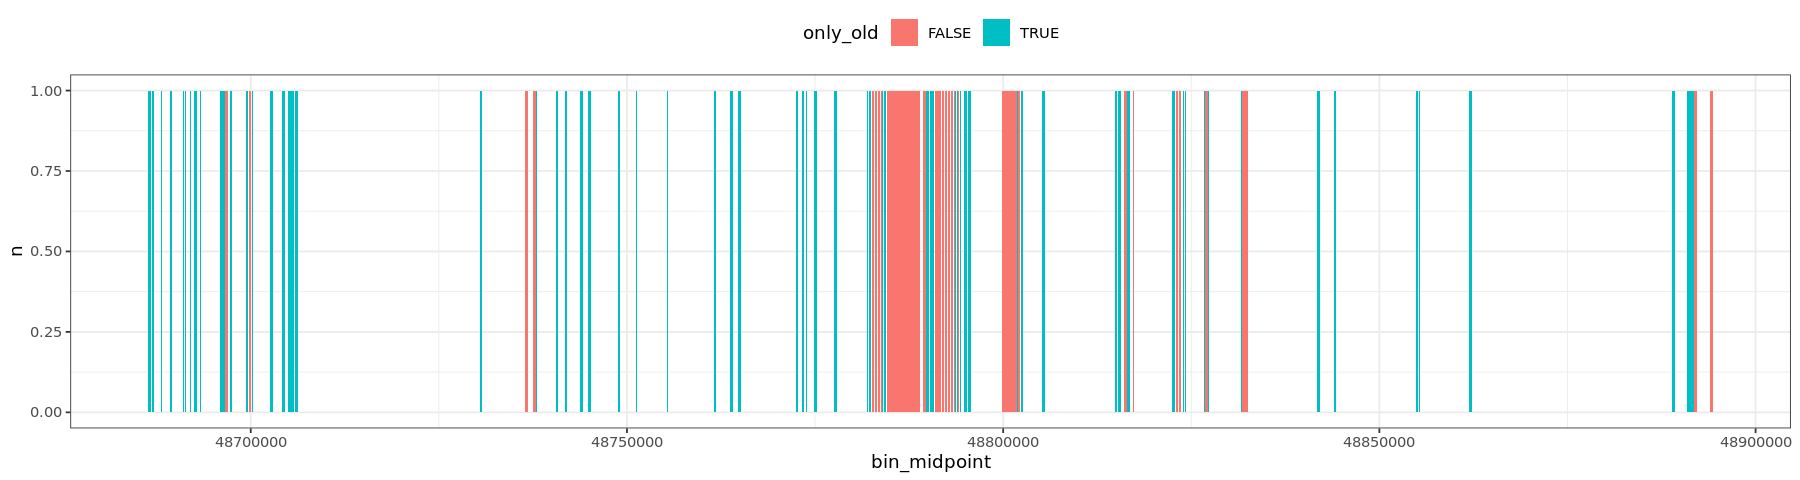

In [21]:
options(repr.plot.width = 15, repr.plot.height = 4)

plotdf %>%
filter(startBin < 50000000) %>%
pivot_longer(cols = contains("adjp"), values_to = "log10fdr", names_to = "analysis_version") %>%
mutate(analysis_version = str_replace(analysis_version,"_adjp","")) %>%
mutate(bin_midpoint = (startBin+endBin)/2) %>%
ggplot(aes(x = bin_midpoint, y = log10fdr, color = analysis_version)) +
geom_point() +
theme_bw() +
theme(legend.position="top")

plotdf %>%
filter(startBin < 50000000) %>%
pivot_longer(cols = contains("adjp"), values_to = "log10fdr", names_to = "analysis_version") %>%
mutate(analysis_version = str_replace(analysis_version,"_adjp","")) %>%
mutate(bin_midpoint = (startBin+endBin)/2) %>%
mutate(only_old = ifelse(is.na(log10fdr), TRUE, FALSE)) %>%
select(bin_midpoint, only_old) %>%
distinct() %>%
group_by(bin_midpoint, only_old) %>%
summarise(n=n()) %>%
ungroup() %>%
ggplot(aes(x = bin_midpoint, y = n, fill = only_old)) +
geom_col(position="identity") +
theme_bw() +
theme(legend.position="top")

Warning message:
“Removed 217 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 217 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 217 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 217 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 217 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 217 rows containing non-finite values (stat_boxplot).”


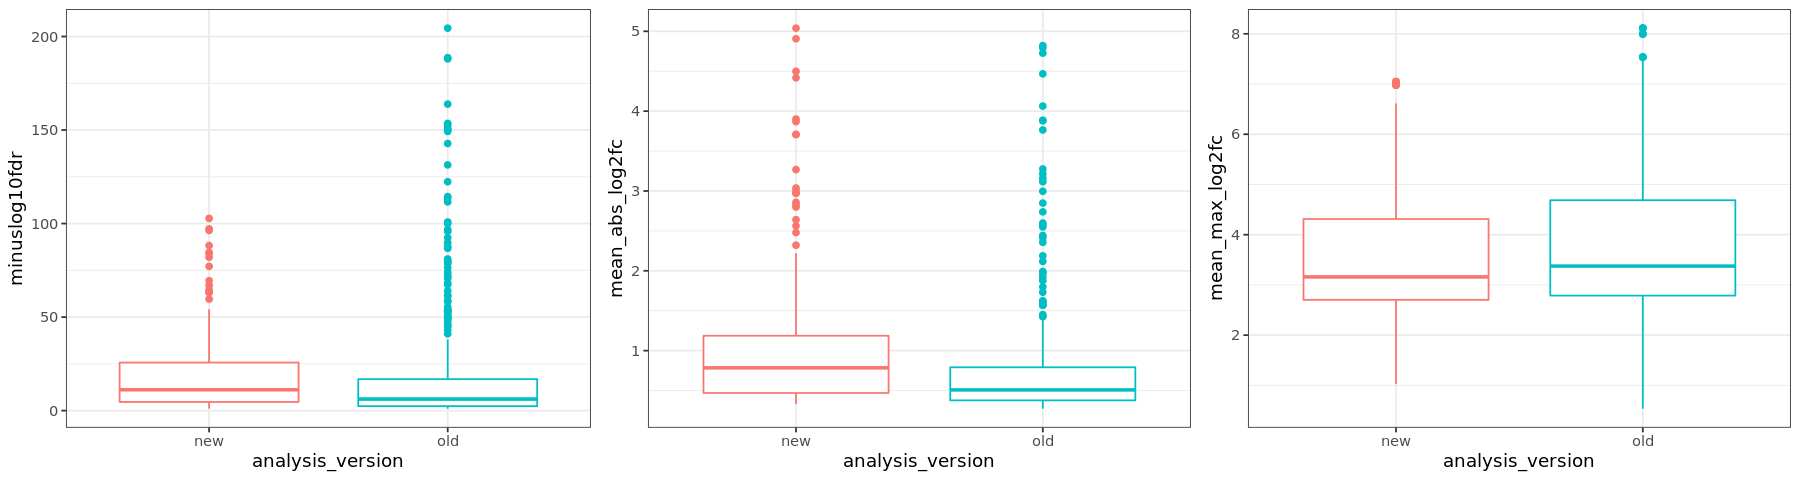

In [22]:
options(repr.plot.width = 15, repr.plot.height = 4)

p1 <- 
plotdf %>%
filter(startBin < 50000000) %>%
pivot_longer(cols = contains("adjp"), values_to = "minuslog10fdr", names_to = "analysis_version") %>%
mutate(analysis_version = str_replace(analysis_version,"_adjp","")) %>%
mutate(bin_midpoint = (startBin+endBin)/2) %>%
ggplot(aes(x = analysis_version, y = minuslog10fdr, color = analysis_version)) +
geom_boxplot() +
theme_bw()

p2 <- 
plotdf %>%
filter(startBin < 50000000) %>%
pivot_longer(cols = contains("abs"), values_to = "mean_abs_log2fc", names_to = "analysis_version") %>%
mutate(analysis_version = str_replace(analysis_version,"_abs_log2fc","")) %>%
mutate(bin_midpoint = (startBin+endBin)/2) %>%
ggplot(aes(x = analysis_version, y = mean_abs_log2fc, color = analysis_version)) +
geom_boxplot() +
theme_bw()

p3 <- 
plotdf %>%
filter(startBin < 50000000) %>%
pivot_longer(cols = contains("max"), values_to = "mean_max_log2fc", names_to = "analysis_version") %>%
mutate(analysis_version = str_replace(analysis_version,"_max_log2fc","")) %>%
mutate(bin_midpoint = (startBin+endBin)/2) %>%
ggplot(aes(x = analysis_version, y = mean_max_log2fc, color = analysis_version)) +
geom_boxplot() +
theme_bw()

ggarrange(p1,p2,p3,
          ncol=3,
          common.legend=TRUE,
          legend="none"
         )

Warning message:
“Removed 217 rows containing missing values (geom_point).”
Warning message:
“Removed 217 rows containing missing values (geom_point).”
Warning message:
“Removed 217 rows containing missing values (geom_point).”


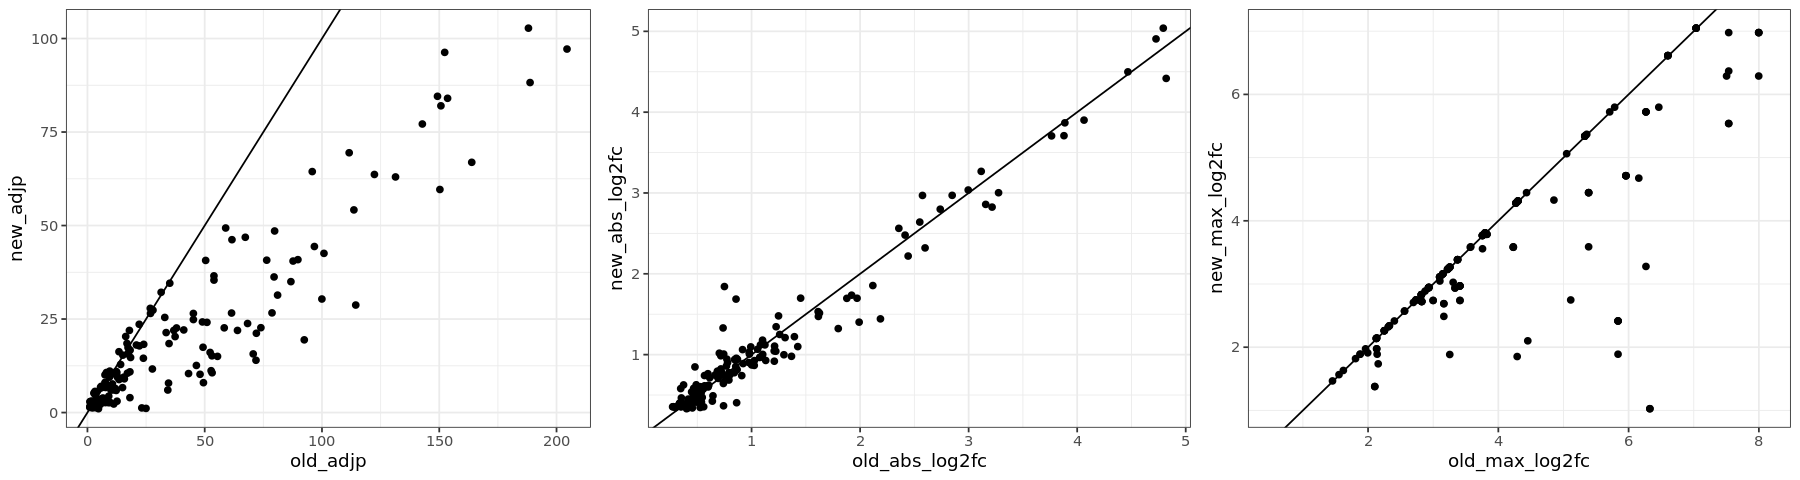

In [23]:
p1 <- 
plotdf %>%
filter(startBin < 50000000) %>%
ggplot(aes(x = old_adjp, y = new_adjp)) +
geom_point() +
geom_abline() +
theme_bw()

p2 <- 
plotdf %>%
filter(startBin < 50000000) %>%
ggplot(aes(x = old_abs_log2fc, y = new_abs_log2fc)) +
geom_point() +
geom_abline() +
theme_bw()

p3 <- 
plotdf %>%
filter(startBin < 50000000) %>%
ggplot(aes(x = old_max_log2fc, y = new_max_log2fc)) +
geom_point() +
geom_abline() +
theme_bw()

ggarrange(p1,p2,p3,ncol=3)

#### Test for significant difference in the significance and log2FC of significant peak calls pre- and post-filter

In [59]:
testdf <-
plotdf %>%
filter(startBin < 50000000) %>%
pivot_longer(cols = contains("adjp"), values_to = "log10fdr", names_to = "analysis_version") %>%
mutate(analysis_version = str_replace(analysis_version,"_adjp","")) %>%
mutate(bin_midpoint = (startBin+endBin)/2) %>%
select(analysis_version, log10fdr)

t.test(data = testdf, log10fdr ~ analysis_version)
wilcox.test(data = testdf, log10fdr ~ analysis_version)


	Welch Two Sample t-test

data:  log10fdr by analysis_version
t = 0.22769, df = 444.83, p-value = 0.82
alternative hypothesis: true difference in means between group new and group old is not equal to 0
95 percent confidence interval:
 -4.300381  5.427397
sample estimates:
mean in group new mean in group old 
         20.18670          19.62319 



	Wilcoxon rank sum test with continuity correction

data:  log10fdr by analysis_version
W = 36965, p-value = 3.507e-05
alternative hypothesis: true location shift is not equal to 0


In [60]:
testdf <-
plotdf %>%
filter(startBin < 50000000) %>%
pivot_longer(cols = contains("abs"), values_to = "mean_abs_log2fc", names_to = "analysis_version") %>%
mutate(analysis_version = str_replace(analysis_version,"_abs_log2fc","")) %>%
mutate(bin_midpoint = (startBin+endBin)/2) %>%
select(analysis_version, mean_abs_log2fc)

t.test(data = testdf, mean_abs_log2fc ~ analysis_version)
wilcox.test(data = testdf, mean_abs_log2fc ~ analysis_version)


	Welch Two Sample t-test

data:  mean_abs_log2fc by analysis_version
t = 3.9101, df = 240.41, p-value = 0.0001201
alternative hypothesis: true difference in means between group new and group old is not equal to 0
95 percent confidence interval:
 0.1682138 0.5097848
sample estimates:
mean in group new mean in group old 
        1.1119611         0.7729618 



	Wilcoxon rank sum test with continuity correction

data:  mean_abs_log2fc by analysis_version
W = 39684, p-value = 6.99e-09
alternative hypothesis: true location shift is not equal to 0


In [61]:
testdf <-
plotdf %>%
filter(startBin < 50000000) %>%
pivot_longer(cols = contains("max"), values_to = "mean_max_log2fc", names_to = "analysis_version") %>%
mutate(analysis_version = str_replace(analysis_version,"_max_log2fc","")) %>%
mutate(bin_midpoint = (startBin+endBin)/2) %>%
select(analysis_version, mean_max_log2fc)

t.test(data = testdf, mean_max_log2fc ~ analysis_version)
wilcox.test(data = testdf, mean_max_log2fc ~ analysis_version)


	Welch Two Sample t-test

data:  mean_max_log2fc by analysis_version
t = -1.7089, df = 318.23, p-value = 0.08845
alternative hypothesis: true difference in means between group new and group old is not equal to 0
95 percent confidence interval:
 -0.52035698  0.03660218
sample estimates:
mean in group new mean in group old 
         3.574052          3.815929 



	Wilcoxon rank sum test with continuity correction

data:  mean_max_log2fc by analysis_version
W = 27052, p-value = 0.0588
alternative hypothesis: true location shift is not equal to 0


In [1]:
%%bash
head -n 1 /data/gersbachlab/lrb53/encodeCrisprWG/lowspecguides/removelowspec.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.fdr01.maxlog2fc.hg38.bed
wc -l /data/gersbachlab/lrb53/encodeCrisprWG/lowspecguides/removelowspec.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.fdr01.maxlog2fc.hg38.bed


chrX	48696600	48696700	chrX:48696600-48696700	7.04791637476902	.
163 /data/gersbachlab/lrb53/encodeCrisprWG/lowspecguides/removelowspec.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.fdr01.maxlog2fc.hg38.bed


In [3]:
%%bash
cd /data/gersbachlab/lrb53/encodeCrisprWG/lowspecguides/

sort -k1,1 -k2,2n removelowspec.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.fdr01.maxlog2fc.hg38.bed > removelowspec.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.sorted.hg38.bed
head -n1 removelowspec.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.sorted.hg38.bed
wc -l removelowspec.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.sorted.hg38.bed

chrX	48696600	48696700	chrX:48696600-48696700	7.04791637476902	.
163 removelowspec.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.sorted.hg38.bed


In [4]:
%%bash
module load bedtools2

cd /data/gersbachlab/lrb53/encodeCrisprWG/lowspecguides/
bedtools merge -d 1 -i removelowspec.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.sorted.hg38.bed > removelowspec.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.sorted.merge.hg38.bed

head -n 1 removelowspec.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.sorted.merge.hg38.bed
wc -l removelowspec.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.sorted.merge.hg38.bed

chrX	48696600	48697000
21 removelowspec.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.sorted.merge.hg38.bed


In [5]:
%%bash
wc -l /data/gersbachlab/lrb53/encodeCrisprWG/manuscript/deseq2/tyckoGATA1krabinterference.deseq2.peakcalls.sorted.merge.bed

68 /data/gersbachlab/lrb53/encodeCrisprWG/manuscript/deseq2/tyckoGATA1krabinterference.deseq2.peakcalls.sorted.merge.bed


The total peak count reduced from 68 to 21 peaks after removing the low spec guides. This suggests that the aggregation of DESeq2 approach is suspectible to false positives by low spec guides/off-target effects.

In [2]:
%%bash
module load bedtools2

bedtools intersect \
-a /data/gersbachlab/lrb53/encodeCrisprWG/lowspecguides/removelowspec.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.sorted.merge.hg38.bed \
-b /data/gersbachlab/lrb53/encodeCrisprWG/manuscript/deseq2/tyckoGATA1krabinterference.deseq2.peakcalls.sorted.merge.bed \
-v 

chrX	48749500	48749700
chrX	48758900	48759000


The two regions only identified in the new peak set are proximal to or very near the GLOD5 TSS.

In [3]:
%%bash
module load bedtools2

bedtools intersect \
-b /data/gersbachlab/lrb53/encodeCrisprWG/lowspecguides/removelowspec.cutsite.tyckoGATA1krabinterference.deseq2.peakcalls.sorted.merge.hg38.bed \
-a /data/gersbachlab/lrb53/encodeCrisprWG/manuscript/deseq2/tyckoGATA1krabinterference.deseq2.peakcalls.sorted.merge.bed \
-v | wc -l 

51
